## 1. Data

Use the .json file

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt

Explore the description dataset

In [2]:
filename_wegvakken = "../data/nwb_wegvakken/2017_09_wegvakken.json"
dict_wegvakken = json.load(open(filename_wegvakken))

In [3]:
print('The dictionary contains two keys ', list(dict_wegvakken.keys()))

print('The features contains {} points'.format(len(dict_wegvakken['features'])))
    
print('Each point contains features ', list(dict_wegvakken['features'][0].keys()))

The dictionary contains two keys  ['type', 'features']
The features contains 1013928 points
Each point contains features  ['type', 'geometry', 'properties']


In [4]:
print('- features')
for k in dict_wegvakken['features'][0].keys():
    print('-- {}'.format(k))
    if k=='type':
        pass
    elif k == 'properties':
        print('-------- {}'.format('WEGBEHSRT'))
    else:
        for kk in dict_wegvakken['features'][0][k].keys():
            print('-------- {}'.format(kk))


- features
-- type
-- geometry
-------- type
-------- coordinates
-- properties
-------- WEGBEHSRT


In [5]:
dict_wegvakken = dict_wegvakken['features']

In [6]:
dict_roadtype = {
    "G": 'Municipality',
    "R": 'Goverment',
    "P": 'Provincie',
    "W": 'Water managerment authorities',
    'T': 'Other type'
}


In [7]:
PROPERTIES_KEY = 'properties'
ROAD_TYPE_KEY = 'WEGBEHSRT'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'

POINTS_PER_METER = 0.1
dx = 200
dy = 200

x_min = 95000
y_min = 427000
x_max = 110000
y_max = 447000
bounding_box = [x_min, y_min, x_max, y_max]

FOLDER_IMG = '../datasets/image_tiles_200/'

### Data Labeling

In [8]:
def add_to_dict(d1, d2, d3, coordinates, rtype):
    """
    d1: dict_tile_contents, tile: road segmentation
    d2: dict_rtype_tile, road type: tiles
    d3: dict_tile_rtype, tile: road type
    """
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)
    d3[tile].add(rtype)

def coord_is_in_bb(coord, bb):
    """Check whether the coordinate is in the bounding box"""
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][ROAD_TYPE_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]

In [9]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
d_tile_rtype = defaultdict(set)

for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    #coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, small_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype,coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, intermediate_coord, rtype)

In [10]:
print("{} tiles contain roads.".format(len(d_tile_contents)))

4947 tiles contain roads.


Here we start to label the all images.

In [11]:
data_img = os.listdir(FOLDER_IMG)

In [12]:
d_tile_label = defaultdict(str)
for img in data_img:
    tmp_road = ''
    for r in list(d_tile_rtype[img]):
        tmp_road += '-'+r
    d_tile_label[img] = tmp_road[1:]

In [13]:
"""Encoder the rtype"""
rtype2int = {'':0, 'G':1, 'P':2, 'R':3, 'W':4, 'T':5, 'M':6}
data_pair = defaultdict(int)
for tile in d_tile_label.keys():
    if len(d_tile_label[tile])>1:
        data_pair[tile] = rtype2int['M']
    else:
        data_pair[tile] = rtype2int[d_tile_label[tile]]

In [14]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W', 5:'T', 6:'M'}

Stats of data

In [15]:
d_rtype_counts = defaultdict(int)
d_rtype_cnt_merge = defaultdict(int)
for img in d_tile_label.keys():
    d_rtype_counts[d_tile_label[img]] += 1
    if len(d_tile_label[img])>1:
        d_rtype_cnt_merge['M'] += 1
    else:
        d_rtype_cnt_merge[d_tile_label[img]] += 1
for i, rt in enumerate(sorted(d_rtype_counts.keys())):
    print(i, rt, d_rtype_counts[rt])

print()
cnt = 0
for rt in sorted(d_rtype_cnt_merge.keys()):
    print(rt, d_rtype_cnt_merge[rt])
    cnt += d_rtype_cnt_merge[rt]

print('\n{}'.format(cnt))

0  2553
1 G 3174
2 G-P 110
3 G-P-R 5
4 G-P-W 12
5 G-R 205
6 G-T 1
7 G-W 232
8 G-W-R 40
9 P 113
10 P-R 2
11 P-W 49
12 P-W-R 1
13 R 70
14 W 863
15 W-R 70

 2553
G 3174
M 727
P 113
R 70
W 863

7500


In [16]:
R_Folder = '../result/week1/'

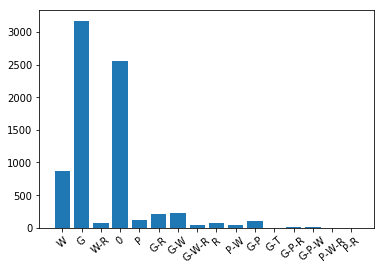

In [18]:
x = [k if len(k)>0 else '0' for k in d_rtype_counts.keys()]
y = [d_rtype_counts[k] if k!='0' else d_rtype_counts[''] for k in x]
x_n = [i for i in range(len(x))]
plt.bar(x_n, y)
#plt.xticks(x_n,x,rotation='vertical')
plt.xticks(x_n,x,rotation=40)
plt.show()

In [85]:
d_rtype_cnt_merge['R']

70

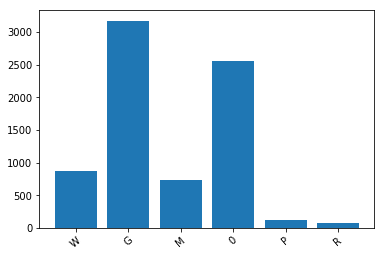

In [19]:
x = [k if len(k)>0 else '0' for k in d_rtype_cnt_merge.keys()]
y = [d_rtype_cnt_merge[k] if k!='0' else d_rtype_cnt_merge[''] for k in x]
x_n = [i for i in range(len(x))]
plt.bar(x_n, y)
#plt.xticks(x_n,x,rotation='vertical')
plt.xticks(x_n,x,rotation=40)
plt.show()

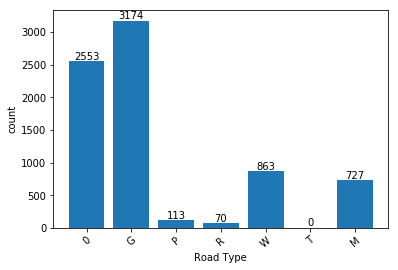

In [26]:
x = sorted(list(int2rtype.keys()))
y = [d_rtype_cnt_merge[int2rtype[k]] if k>0 else d_rtype_cnt_merge[''] for k in x]
x_label = [int2rtype[k] for k in x]

bar = plt.bar(x, y)
plt.xticks(x,x_label,rotation=40)

for i, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{}'.format(height), ha='center', va='bottom')

plt.xlabel('Road Type')
plt.ylabel('count')

plt.savefig('../results/rtype_stats.pdf')

plt.show()

Split dataset into train dataset and validatiaon dataset

In [17]:
TRAIN_SIZE = 6000
VAL_SIZE = 1500

In [18]:
data = list(data_pair)
random.shuffle(data)
data_train = data[:TRAIN_SIZE]
data_val = data[TRAIN_SIZE:]

In [115]:
# import pickle

# with open('train_imgs.pkl', 'wb') as f:
#     pickle.dump(mylist, f)

Create Dataset and DataLoader

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [20]:
class Insight_Dataset(Dataset):
    """
    The size of image is (3, 256, 256)
    """
    def __init__(self, img_folder, data, pair):
        self.folder = img_folder
        self.data = data
        #self.keys = list(d_tile_label.keys()).sort(key=lambda x: [int(x.split('_')[0]), int(x.split('_')[1])])
        self.pair = pair
    
    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        '''
        return （image, label）
        '''
        tile_name = self.folder + self.data[idx]
        img = plt.imread(tile_name)
        label = self.pair[self.data[idx]]
        return (torch.FloatTensor(img.T), label)


In [21]:
BATCH_SIZE = 32
train_data = Insight_Dataset(FOLDER_IMG, data_train, data_pair)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_data = Insight_Dataset(FOLDER_IMG, data_val, data_pair)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64 , (3, 3), stride=(1, 1), padding=1)
        self.conv2 = nn.Conv2d(64, 64 , (3, 3), stride=(2, 2), padding=1)
        
        self.conv3 = nn.Conv2d(64, 128 , (3, 3), stride=(1, 1), padding=1)
        self.conv4 = nn.Conv2d(128, 128 , (3, 3), stride=(2, 2), padding=1)
        
        self.conv5 = nn.Conv2d(128, 256 , (3, 3), stride=(1, 1), padding=1)
        self.conv6 = nn.Conv2d(256, 256 , (3, 3), stride=(1, 1), padding=1)
        
        self.conv7 = nn.Conv2d(256, 512 , (3, 3), stride=(1, 1), padding=1)
        self.conv8 = nn.Conv2d(512, 512 , (3, 3), stride=(1, 1), padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2,2), stride = (2,2))
        self.linear = nn.Linear(512*4*4, 7)
        
       
        
    def forward(self, img):
        hidden = self.relu(self.conv1(img))
        hidden = self.relu(self.conv2(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv3(hidden))
        hidden = self.relu(self.conv4(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv5(hidden))
        hidden = self.relu(self.conv6(hidden))
        hidden = self.maxpool(hidden)
        
        hidden = self.relu(self.conv7(hidden))
        hidden = self.relu(self.conv8(hidden))
        hidden = self.maxpool(hidden)
        
        out = hidden.view(hidden.size(0), -1)
        out = self.linear(out)
        
        return out 

In [51]:
model = CNN()

In [52]:
b = model(a)

In [53]:
b.shape

torch.Size([1, 7])

# Training the model

In [55]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0
    criterion_test = nn.CrossEntropyLoss()
    model.eval()
    torch.no_grad()
    for (imgs, labels) in loader:
        imgs, labels = imgs.to(device),  labels.to(device)
        outputs = model(imgs)
        
        loss_test = float(criterion_test(outputs, labels))
        total_loss += loss_test       
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss/len(loader)

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [62]:
model = CNN().to(device)

In [63]:
model_name = '../models/week1.pt'
best_val_acc = 0

In [64]:
learning_rate = 1e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_record = []
train_acc_record = []
val_loss_record = []
train_loss_record = []
step_record = []

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(imgs.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i >0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            train_acc, train_loss = test_model(train_loader, model)
            train_acc_record.append(train_acc)
            train_loss_record.append(train_loss)
            step_record.append(i + epoch*total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Val Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_loss, train_acc, val_acc))
            if val_acc > best_val_acc:
                with open(model_name, 'wb') as f:
                    torch.save(model, f)
                    best_val_loss = val_loss

# training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
# pkl.dump(training_curve, open(result_FILE, "wb"))

Epoch: [1/5], Step: [101/188], Train Loss: 1.2566126264790272, Train Acc: 57.45, Val Acc: 56.6


/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [101/188], Train Loss: 0.9233124330639839, Train Acc: 66.56666666666666, Val Acc: 66.8
Epoch: [3/5], Step: [101/188], Train Loss: 0.9628773743801928, Train Acc: 65.33333333333333, Val Acc: 67.6
Epoch: [4/5], Step: [101/188], Train Loss: 1.0036077743515055, Train Acc: 64.08333333333333, Val Acc: 62.333333333333336
Epoch: [5/5], Step: [101/188], Train Loss: 0.8414420770837906, Train Acc: 69.0, Val Acc: 68.53333333333333


# Analyze Result

In [87]:
val_data = Insight_Dataset(FOLDER_IMG, data_val, data_pair)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size = 1,
                                        shuffle = False)

In [97]:
correct = defaultdict(int)
fault = defaultdict(list)
total = defaultdict(int)
total_loss = defaultdict(int)

model.eval()
torch.no_grad()


for i, (img, label) in enumerate(val_loader):
    img = img.to(device)
    outputs = model(img)

    #loss_test = float(criterion_test(outputs, labels))
    #total_loss += loss_test       
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    pred = np.asarray(predicted)[0][0]
    label = np.asarray(label)[0]
    if pred==label:
        correct[label] += 1
    else:
        fault[label].append([i, pred])
    total[label]+= 1

    #total += labels.size(0)
    #correct += predicted.eq(labels.view_as(predicted)).sum().item()

In [103]:
accuracy = defaultdict(float)
for k in total.keys():
    accuracy[k] = correct[k]/total[k]
accuracy

defaultdict(float,
            {4: 0.18823529411764706,
             0: 0.8141263940520446,
             1: 0.9088,
             3: 0.0,
             6: 0.0,
             2: 0.0})

In [104]:
total

defaultdict(int, {4: 170, 0: 538, 1: 625, 3: 17, 6: 134, 2: 16})

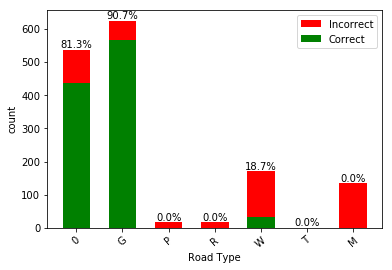

In [140]:
#int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W', 5:'T', 6:'M'}
x = sorted(list(int2rtype.keys()))
total_cnt = [total[k] for k in x]
correct_cnt = [correct[k] for k in x]
x_label = [int2rtype[k] for k in x]

ax = plt.subplot(111)
bar = ax.bar(x, total_cnt, width=0.6, color='r', align='center', label = 'Incorrect')
ax.bar(x, correct_cnt, width=0.6, color='g', align='center', label = 'Correct')
#ax.bar(x+0.2, k, width=0.2, color='r', align='center')

# plt.bar(x, y2)
# plt.bar(x, y)
plt.xticks(x,x_label,rotation=40)

for i, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}%'.format(100*correct_cnt[i]/(total_cnt[i]+1)), ha='center', va='bottom')
    
plt.legend()
plt.xlabel('Road Type')
plt.ylabel('count')
plt.savefig('../results/week1/val_acc.pdf')
plt.show()

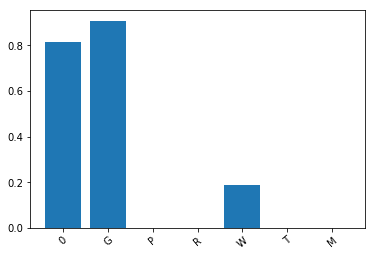

In [111]:
y = y = [accuracy[k] for k in x]
plt.bar(x,y)
plt.xticks(x,x_label,rotation=40)
plt.show()

In [ ]:
def model_acc_analysis(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = defaultdict(int)
    fault = defaultdict(list)
    total = defaultdict(int)
    total_loss = defaultdict(int)
    #criterion_test = nn.CrossEntropyLoss()
    model.eval()
    torch.no_grad()
    
    for i, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device),  labels.to(device)
        outputs = model(imgs)
        
        #loss_test = float(criterion_test(outputs, labels))
        #total_loss += loss_test       
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss/len(loader)

# Save works of today